# RBM (Restrictive Boltzmann Machine)

**Energy based model**

> Assigns lower energy values to more relevant features and higher energy values for less important features.

> **Objective**: minimize the energy value.


> **Restrictive**: because the neurons inside the same layer are not connected, but they are fully connected with the neurons in the next layer.

To find the optimal weight W, which minimizes the energy function E, we use **SGD**(Stochastic Gradient Descent). For this we need to compute the derivative of E with respect to v and h (visible and hidden neuron's input), which in turn gives us 2 terms, a positive and negative gradient. 

Positive phase increases the probability of the training data, while the negative decreases it.

To adjust the weights we use the "Contrastive Divergence" algorithm, which build an update matrix that allows to alter incrementally the value of W.
W_new = W + learning_rate * CD

The RBM is trained through several forward and backward passes until it is able to extract the most important features/patterns.
> * **Forward pass**: input processing
> * **Backward pass**: reconstruction


In [137]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [177]:
class RBM():
  def __init__(self, nv, nh):
    """
    nv = nr of neurons in the visible layer
    nh = nr of neurons in the hidden layer
    """
    self.nv = nv
    self.nh = nh

    # initiliaze the weight matrix
    self.W = tf.Variable(tf.random.normal([self.nv, self.nh]))
    # bias for hidden layer (initialized with 0)
    self.hb = tf.Variable(np.zeros(self.nh).astype(np.float32))
    # bias for visible layer (initialized with 0)
    self.vb = tf.Variable(np.zeros(self.nv).astype(np.float32))

  def forward_pass(self, v):
    """
     forward pass: compute a sample hidden activation vector (h)
    """
    _h = tf.nn.sigmoid(tf.matmul(v, self.W) + self.hb)
    # compute probability using a relu function
    h = tf.nn.relu(tf.sign(_h - tf.random.uniform(tf.shape(_h))))
    return h

  def backward_pass(self, h):
    """
     backward pass: compute a sample visible activation vector (v)
    """
    _v = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.vb)
    # compute probability using a relu function
    v = tf.nn.relu(tf.sign(_v - tf.random.uniform(tf.shape(_v))))
    return v

  def one_pass(self, v):
    """
    Represent a forward & backward pass through the network
    """
    h = tf.nn.sigmoid(tf.matmul(v, self.W) + self.hb)
    return tf.matmul(h, tf.transpose(self.W)) + self.vb

  def reconstruct(self, x):
    """
    Return the reconstructed image based on the previously learned weights
    """
    return tf.nn.sigmoid(self.one_pass(x))

  def compute_CD(self, v0, h0, v1, h1):
    """
     compute the CD to maximize
    """
    # positive weight gradient
    w_pos_grad = tf.matmul(tf.transpose(v0), h0)
    # negative weight gradient
    w_neg_grad = tf.matmul(tf.transpose(v1), h1)
    # compute the difference between these 2 gardients
    CD = tf.reduce_mean(w_pos_grad - w_neg_grad)
    return CD

  def update_CD(self, v0, h0, v1, h1, lr=0.001):
    # compute the CD to maximize
    CD = self.compute_CD(v0, h0, v1, h1)
    # update weights using CD
    self.W = self.W + lr * CD
    # update the biases
    self.vb = self.vb + lr * tf.reduce_mean(v0 - v1, 0)
    self.hb = self.hb + lr * tf.reduce_mean(h0 - h1, 0)

  def LMS_loss(self, v0, v1):
    """
    LMS(Least Mean Squared) error computed based on the original and reconstructed input. 
    """
    loss = tf.math.abs(v0 - v1)
    return tf.reduce_mean(loss * loss)

  def free_energy(self, v):
    """
    Free energy is the energy that a single configuration would need in order to 
    have the same probability as all configurations containing v.
    """
    # transform the visible bias to a column vector
    b = tf.reshape(self.vb, (nv, 1))
    visible_term = tf.matmul(v, b)
    # transform the result of the matrix multiplication back to a row vector
    visible_term = tf.reshape(visible_term, (1,-1))

    hidden_term = tf.nn.softplus(tf.matmul(v, self.W) + self.hb)
    hidden_term = tf.reduce_sum(hidden_term)

    return - visible_term - hidden_term

  def update_SGD(self, x, lr=0.001):
    """
    SGD: find the optimal weights which minimize the energy function.
    """
    # gradient descent optimizer used to minize the energy
    optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=lr)
    
    with tf.GradientTape() as tape:
      # forward pass: initial hidden prob vector based on the input v0
      h = self.forward_pass(x)
      # backward pass: reconstruct the input
      v = self.backward_pass(h)
      # calculate the energy value of x (visible) and v (hidden vector)
      energy = tf.reduce_mean(self.free_energy(x) - self.free_energy(v))

    # compute the gradients
    grads = tape.gradient(energy, [self.W, self.hb, self.vb])
    # update the weight and biases
    optimizer.apply_gradients(zip(grads, [self.W, self.hb, self.vb]))

    return v


  def cross_entropy_loss(self, x, v):
    # pass the input through the visible and hidden layers and back
    reconstructed_input = self.one_pass(x)
    # calculate the cross-entropy loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=self.x, 
        logits=reconstructed_input)
    loss = tf.reduce_mean(loss)
    return loss

  def train(self, X, lr=0.01, batch_size=64, epochs=15):
      nr_inputs = X.shape[0]
      train_losses = []

      for epoch in range(0, epochs):
        epoch_loss = 0
        s = 0
        for i in range(0, nr_inputs - batch_size, batch_size):
          # extract the next batch of data (input to the visible nodes)
          x = X[i:i+batch_size].reshape(batch_size, -1)
          # update the weight matrix and the visible bias & hidden bias
          v = self.update_SGD(x, lr)
          # calculate the loss comparing
          loss = self.LMS_loss(x, v)
          # loss = self.cross_entropy_loss(v0, v1)
          epoch_loss += loss
          s += 1
          train_losses.append(loss)

        print('Epoch: ', epoch, ', train loss:', end =" ")
        tf.print(epoch_loss/s)

      self.plot_loss(train_losses)

      return np.asarray(train_losses).mean()

  def test(self, X_test, batch_size=32):
      nr_inputs = X_test.shape[0]
      test_losses = []

      for i in range(0, nr_inputs - batch_size, batch_size):
          # extract the next batch of data (input to the visible nodes)
          v0 = X_test[i:i+batch_size].reshape(batch_size, -1)
          # # forward pass: initial hidden prob vector based on the input v0
          h0 = self.forward_pass(v0)
          # # backward pass: reconstruct the input
          v1 = self.backward_pass(h0)
          # calculate the loss comparing
          loss = self.LMS_loss(v0, v1)
          # loss = self.cross_entropy_loss(v0, v1)
          test_losses.append(loss)

      self.plot_loss(test_losses)

      return np.asarray(test_losses).mean()

  def plot_loss(self, loss):
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(loss)
    plt.show()

In [168]:
def preprocess_input(x):
  # shuffle the data
  x = np.random.permutation(x)
  # normalize input values
  x = x / 255.0
  x = x.astype(np.float32)
  return x

In [157]:
# load and prepare the input dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = preprocess_input(x_train)
X_test = preprocess_input(x_test)

In [178]:
nv = X_train.shape[1] * X_train.shape[2]
nh = 100
rbm = RBM(nv, nh)

Epoch:  0 , train loss: 0.130816057
Epoch:  1 , train loss: 0.0998634323
Epoch:  2 , train loss: 0.094637
Epoch:  3 , train loss: 0.0910572857
Epoch:  4 , train loss: 0.0885081589
Epoch:  5 , train loss: 0.0863938555
Epoch:  6 , train loss: 0.084132
Epoch:  7 , train loss: 0.0823586881
Epoch:  8 , train loss: 0.0808843523
Epoch:  9 , train loss: 0.079640612
Epoch:  10 , train loss: 0.0786758214
Epoch:  11 , train loss: 0.0778240561
Epoch:  12 , train loss: 0.0767969042
Epoch:  13 , train loss: 0.0762105212
Epoch:  14 , train loss: 0.0756461397


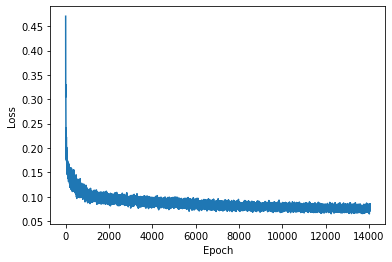

Train Error:  0.08689634
Train Accuracy:  0.9131036624312401


In [179]:
# train the model
train_error = rbm.train(X_train)
print("Train Error: ", train_error)
print("Train Accuracy: ", 1 - train_error)

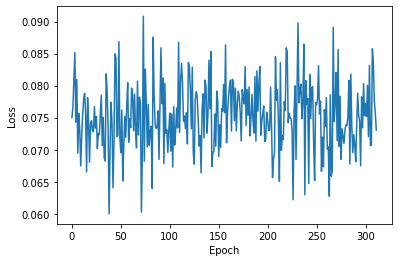

Test Error:  0.07524795
Test Accuracy:  0.9247520491480827


In [180]:
# test the model on the test set
test_error = rbm.test(X_test)
print("Test Error: ", test_error)
print("Test Accuracy: ", 1 - test_error)

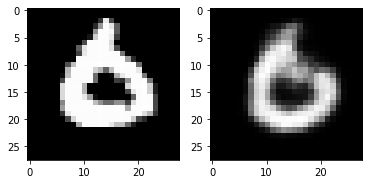

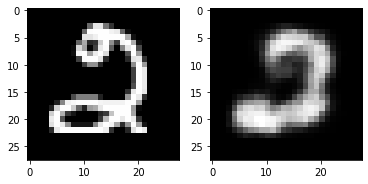

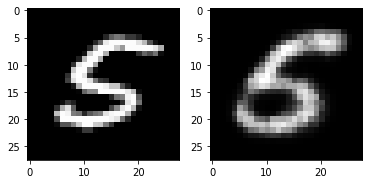

In [189]:
# verify the model on a few sample data from the test set
nr_samples = 3  
# generate nr_samples random indices to select a sample subset from the test set
rand_indices = np.random.choice(X_test.shape[0], nr_samples, replace=False)
rand_samples = X_test[rand_indices]
# flatten the image data (matrix of pixels) to a 1D array (feature vector)
flattened_samples = rand_samples.reshape(nr_samples, -1)
# reconstruct the images
reconstructed_samples = rbm.reconstruct(flattened_samples)
# cpnvert the 1D outputs to the original 2D image shape
reconstructed_samples = reconstructed_samples.numpy().reshape(rand_samples.shape)

# display the samples
for i in range(0,nr_samples):
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(rand_samples[i], cmap='gray')
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(reconstructed_samples[i], cmap='gray')